In [1]:
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error, max_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from getdata import GetDataset
from typing import Union
import visuals as vs
import pandas as pd
import numpy as np
import seaborn as sns

Obtención del dataset

In [2]:
data,target = GetDataset(CreateDataFrame=True).Outputdata()

Cambio a base lineal y equisdistante

In [3]:
x = np.linspace(data[0][0].min(),data[0][0].max(),901)
data_lin = np.zeros((data.shape[0],data.shape[2]))
for i in range(data.shape[0]):
    data_lin[i,:] = np.interp(x,data[i][0],data[i][1])

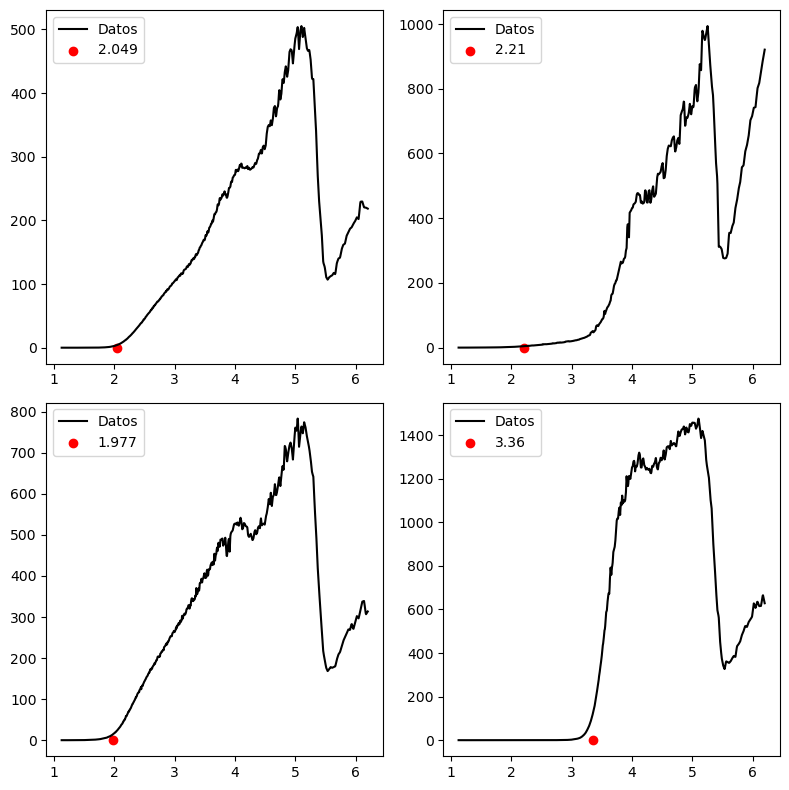

In [4]:
ids = np.random.randint(0, data_lin.shape[0], size=4)
fig,ax = plt.subplots(2,2,figsize=(8,8))

for i,id in enumerate(ids):
    ax[i//2,i%2].plot(x,data_lin[id],color='black')
    ax[i//2,i%2].scatter(target[id],y=0,color='red')
    ax[i//2,i%2].legend(["Datos",target[id].astype('str')])
plt.tight_layout()
plt.show()

Scorer


In [5]:
MSE_scorer = make_scorer(mean_squared_error,greater_is_better=False)

Extracción de caracteristicas

In [6]:
def TranformData(data):
    datatrans = np.zeros((data.shape[0],12))
    for i,element in enumerate(data):
        # 1. Valor máximo de la curva
        valor_maximo = np.max(element)
        # 2. Área bajo la curva (usando la regla del trapecio)
        area_bajo_curva = np.trapz(element)

        # 3. Tiempo de subida
        tiempo_de_subida = np.argmax(element)

        # 4. Tiempo de decaimiento
        tiempo_de_decaimiento = len(element) - tiempo_de_subida

        # 5. Tiempo medio de vida
        tiempo_medio_vida = (tiempo_de_subida + tiempo_de_decaimiento) / 2

        # 6. Pendiente máxima
        pendiente_maxima = np.max(np.gradient(element))

        # 7. Pendiente mínima
        pendiente_minima = np.min(np.gradient(element))

        # 8. Pendiente promedio
        pendiente_promedio = np.mean(np.gradient(element))


        # 9. Valor medio
        valor_medio = np.mean(element)

        # 10. Desviación estándar
        desviacion_estandar = np.std(element)

        # 11. Asimetría
        asimetria = np.mean((element - valor_medio) ** 3) / (np.std(element) ** 3)

        # 12. Curtosis
        curtosis = np.mean((element - valor_medio) ** 4) / (np.std(element) ** 4)

        dat = np.array([valor_maximo,area_bajo_curva,tiempo_de_subida,tiempo_de_decaimiento,tiempo_medio_vida,pendiente_maxima,pendiente_minima,pendiente_promedio,valor_medio,desviacion_estandar,asimetria,curtosis]).reshape(1,12)
        datatrans[i,:] = dat[:]
    columns = ['Valor_Maximo','ABC','Timp_Subida','Timp_Bajada','Timp_Med','Pendiente_Max','Pendiente_Min','Pendiente_Med','Valor_Medio','Desv_est','Asimetria','Curtosis']
    datat = pd.DataFrame(datatrans,columns=columns)
    return datat

new_data_frame = TranformData(data_lin)
new_data_array = np.array(new_data_frame)

Normalización de datos y división del dataset

In [7]:
min_data = MinMaxScaler().fit_transform(new_data_array)
stand_data = StandardScaler().fit_transform(new_data_array)
robs_data = RobustScaler().fit_transform(new_data_array)
pt_data_min = PowerTransformer(method='yeo-johnson').fit_transform(min_data)
pt_data_std = PowerTransformer(method='yeo-johnson').fit_transform(stand_data)
pt_data_robs = PowerTransformer(method='yeo-johnson').fit_transform(robs_data)
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(pt_data_min, target, test_size=0.2, random_state=42, shuffle=True)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(pt_data_std, target, test_size=0.2, random_state=42, shuffle=True)
X_train_robs, X_test_robs, y_train_robs, y_test_robs = train_test_split(pt_data_robs, target, test_size=0.2, random_state=42, shuffle=True)

Reducción de dimensionalidad PCA

MinMaxScaler

In [8]:
pca_min = PCA()
X_train_pca_min = pca_min.fit_transform(X_train_min)
X_test_pca_min = pca_min.transform(X_test_min)

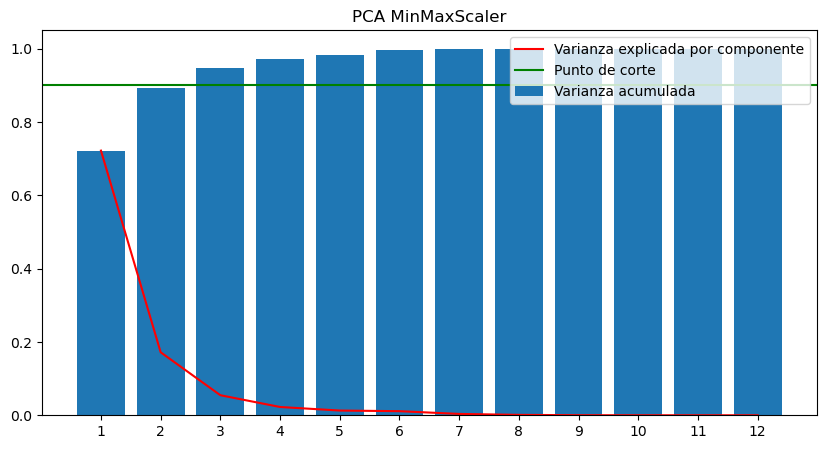

In [9]:
plt.figure(figsize=(10,5))
plt.plot(range(1,pca_min.explained_variance_ratio_.shape[0]+1),pca_min.explained_variance_ratio_, c='red', label='Varianza explicada por componente')
plt.bar(range(1,pca_min.explained_variance_ratio_.shape[0]+1), height=np.cumsum(pca_min.explained_variance_ratio_), label='Varianza acumulada')
plt.axhline(y=0.9, c='g', label='Punto de corte')
plt.title('PCA MinMaxScaler')
plt.xticks(range(1,pca_min.explained_variance_ratio_.shape[0]+1))
plt.legend(loc=1)
plt.show()

,Explained Variance,Valor_Maximo,ABC,Timp_Subida,Timp_Bajada,Timp_Med,Pendiente_Max,Pendiente_Min,Pendiente_Med,Valor_Medio,Desv_est,Asimetria,Curtosis
Dimension 1,0.7218,0.3378,0.3482,-0.2424,0.2404,0.0,0.3242,-0.3256,0.2561,0.3482,0.3439,-0.2434,-0.2695
Dimension 2,0.1718,-0.1859,-0.0831,-0.4695,0.4710,-0.0,-0.2124,0.1841,-0.4075,-0.0834,-0.1444,-0.3878,-0.3050


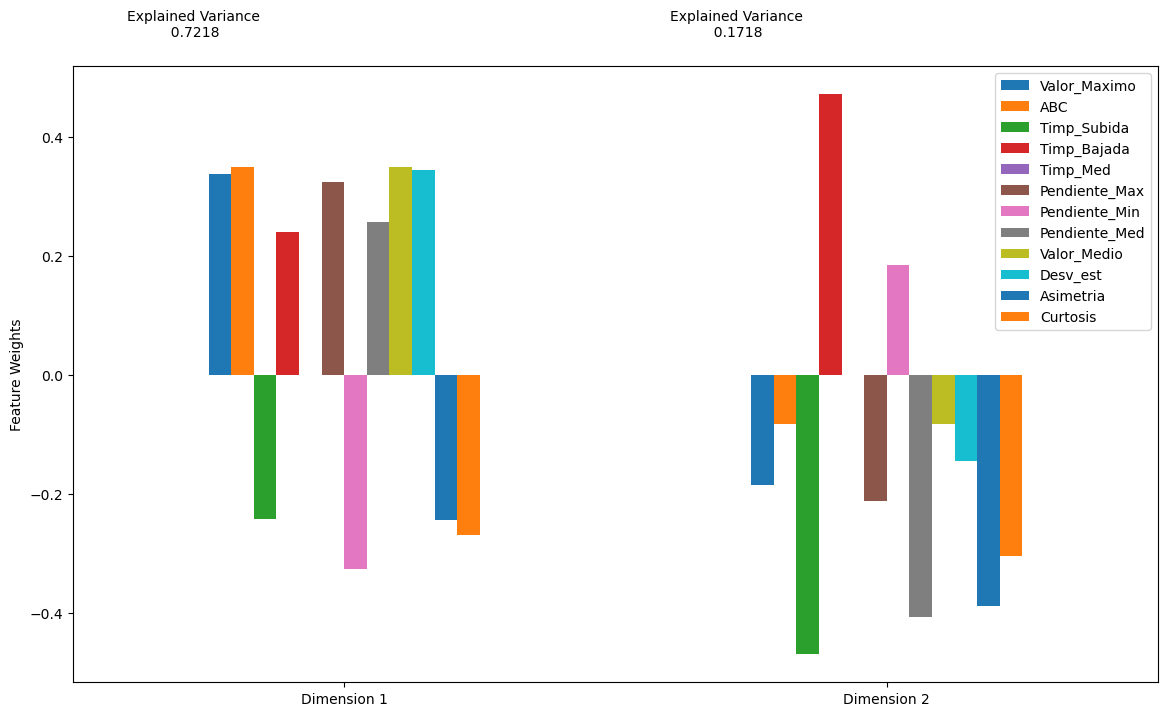

In [10]:
vs.pca_results(pd.DataFrame(X_train_pca_min,columns=new_data_frame.columns),pca_min,2)

StandarScaler

In [11]:
pca_std = PCA()
X_train_pca_std = pca_std.fit_transform(X_train_std)
X_test_pca_std = pca_std.transform(X_test_std)

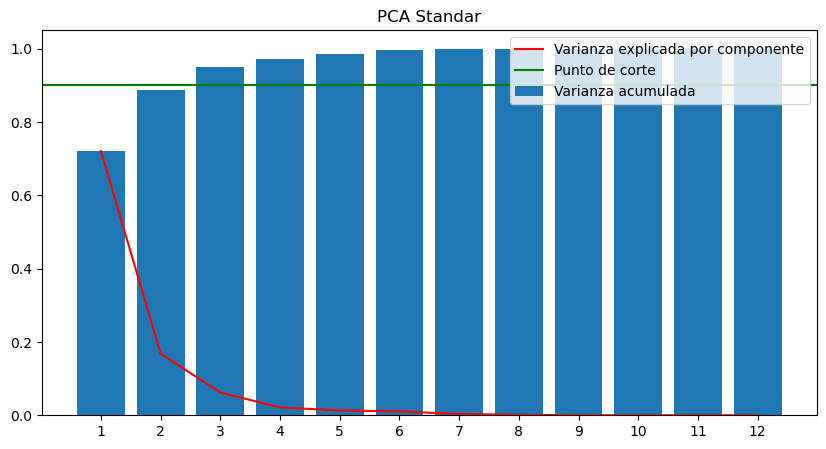

In [12]:
plt.figure(figsize=(10,5))
plt.plot(range(1,pca_std.explained_variance_ratio_.shape[0]+1),pca_std.explained_variance_ratio_, c='red', label='Varianza explicada por componente')
plt.bar(range(1,pca_std.explained_variance_ratio_.shape[0]+1), height=np.cumsum(pca_std.explained_variance_ratio_), label='Varianza acumulada')
plt.axhline(y=0.9, c='g', label='Punto de corte')
plt.title('PCA Standar')
plt.xticks(range(1,pca_std.explained_variance_ratio_.shape[0]+1))
plt.legend(loc=1)
plt.show()

,Explained Variance,Valor_Maximo,ABC,Timp_Subida,Timp_Bajada,Timp_Med,Pendiente_Max,Pendiente_Min,Pendiente_Med,Valor_Medio,Desv_est,Asimetria,Curtosis
Dimension 1,0.7203,0.3386,0.3482,-0.2349,0.2349,-0.0,0.3280,-0.3307,0.2598,0.3482,0.3444,-0.2382,-0.2696
Dimension 2,0.1677,-0.1845,-0.0862,-0.4968,0.4968,-0.0,-0.1924,0.1542,-0.4094,-0.0865,-0.1475,-0.3639,-0.2735


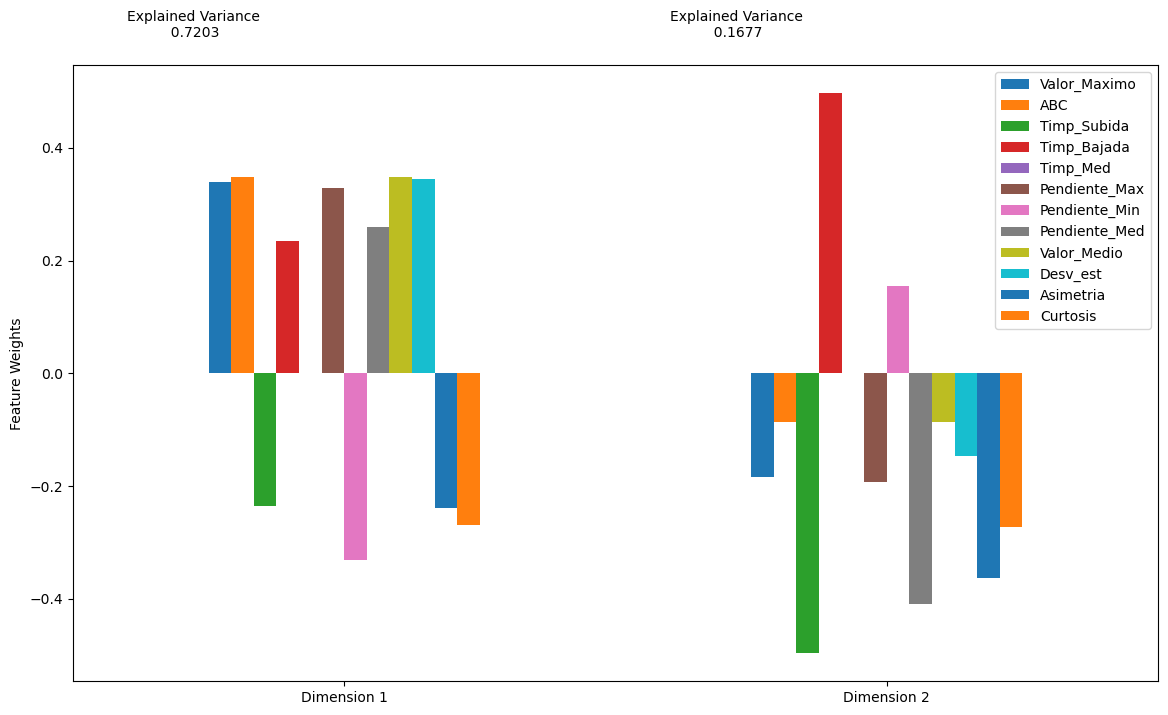

In [13]:
vs.pca_results(pd.DataFrame(X_train_pca_std,columns=new_data_frame.columns),pca_std,2)

RobustScaler

In [14]:
pca_rob = PCA()
X_train_pca_rob = pca_rob.fit_transform(X_train_robs)
X_test_pca_rob = pca_rob.transform(X_test_robs)

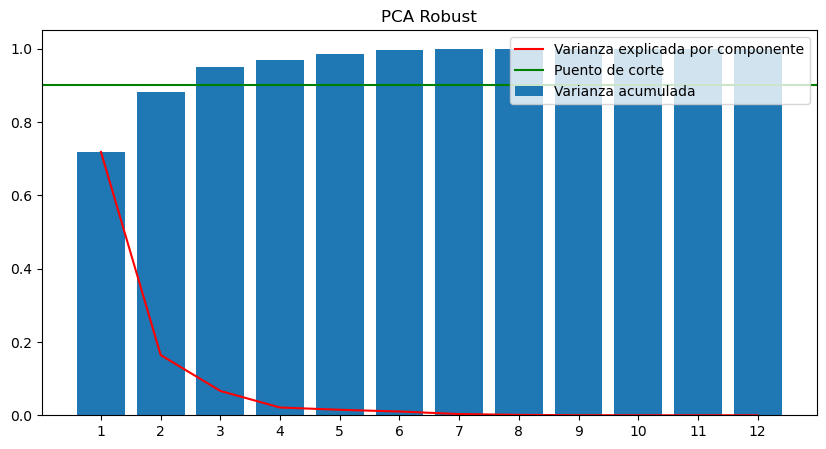

In [15]:
plt.figure(figsize=(10,5))
plt.plot(range(1,pca_rob.explained_variance_ratio_.shape[0]+1),pca_rob.explained_variance_ratio_, c='red', label='Varianza explicada por componente')
plt.bar(range(1,pca_rob.explained_variance_ratio_.shape[0]+1), height=np.cumsum(pca_rob.explained_variance_ratio_), label='Varianza acumulada')
plt.axhline(y=0.9, c='g', label='Puento de corte')
plt.title('PCA Robust')
plt.xticks(range(1,pca_rob.explained_variance_ratio_.shape[0]+1))
plt.legend(loc=1)
plt.show()

,Explained Variance,Valor_Maximo,ABC,Timp_Subida,Timp_Bajada,Timp_Med,Pendiente_Max,Pendiente_Min,Pendiente_Med,Valor_Medio,Desv_est,Asimetria,Curtosis
Dimension 1,0.7182,0.3390,0.3486,-0.2352,0.2352,0.0,0.3322,-0.3334,0.2572,0.3486,0.3450,-0.2331,-0.2652
Dimension 2,0.1644,-0.1875,-0.0866,-0.5008,0.5008,-0.0,-0.1781,0.1325,-0.4251,-0.0868,-0.1485,-0.3599,-0.2582


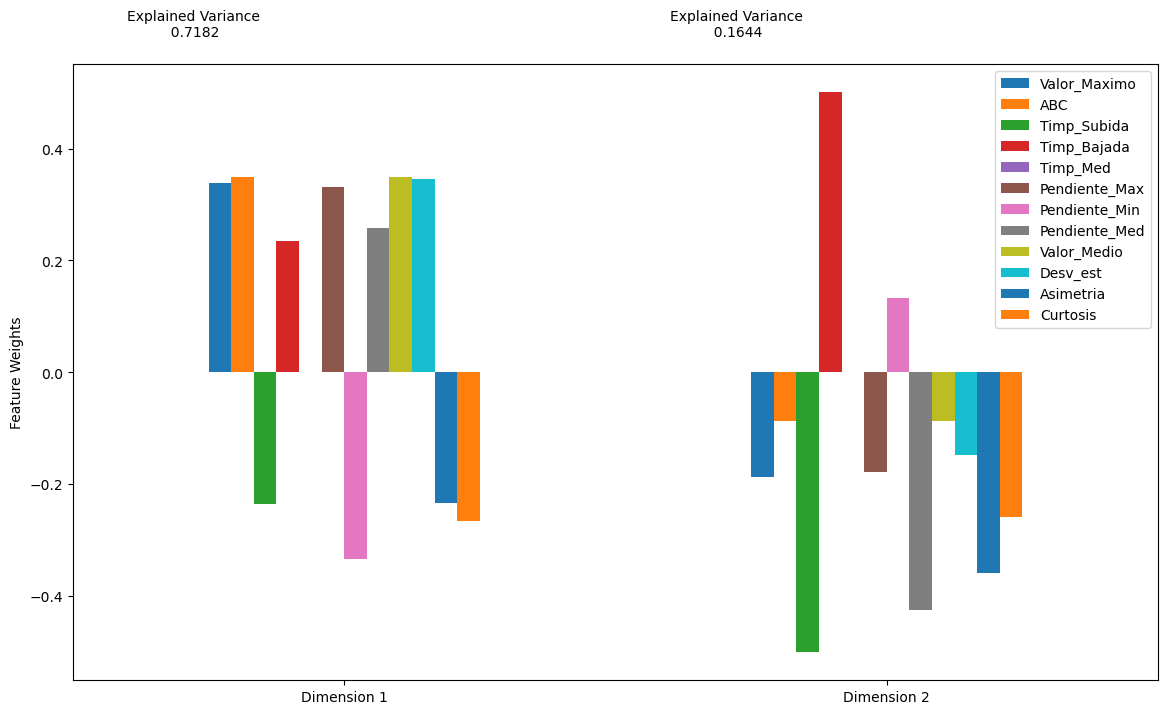

In [16]:
vs.pca_results(pd.DataFrame(X_train_pca_rob,columns=new_data_frame.columns),pca_rob,2)

Busqueda de parametros

In [17]:
def Results(data:list,view:str)->pd.DataFrame:
    Metrics = pd.DataFrame(data,columns=[view,'MSE','RMSE','MAE','R2','Max_Error'])
    metrics_name = []
    metrics_value = []
    for column in Metrics.columns[1:]:
        if column == 'R2':
            val_sorted = Metrics[column].sort_values(ascending=False)
            indices_originales = pd.Series(val_sorted.index, index=val_sorted.values)
            metrics_value.append(pd.DataFrame(np.array(val_sorted),index=None,columns=[column]))
            metrics_name.append(pd.DataFrame(np.array(Metrics.iloc[indices_originales,0]),index=None,columns=[column]))

        else:
            val_sorted = Metrics[column].sort_values(ascending=True)
            indices_originales = pd.Series(val_sorted.index, index=val_sorted.values)
            metrics_value.append(pd.DataFrame(np.array(val_sorted),index=None,columns=[column]))
            metrics_name.append(pd.DataFrame(np.array(Metrics.iloc[indices_originales,0]),index=None,columns=[column]))
    Metrics_values = pd.concat(metrics_value,axis=1)
    Metrics_name = pd.concat(metrics_name,axis=1)

    df_combined = pd.DataFrame()
    for column in Metrics_name.columns:
        # Concatenamos los valores de las columnas de ambos DataFrames, con los valores de Metrics_name entre paréntesis
        df_combined[column] = Metrics_name[column] + ' (' + round(Metrics_values[column],3).astype(str) + ')'

    # Muestra el DataFrame combinado
    return df_combined

In [18]:
def ParamsSearch(model,
                 X:np.ndarray,
                 y:np.ndarray,
                 params:dict,
                 scoring:Union[np.ndarray,list,tuple]=MSE_scorer,
                 n_iters:int=200) -> dict:
    grid_search = RandomizedSearchCV(model, params, cv=5, scoring=scoring,n_jobs=-1,n_iter=n_iters)
    grid_search.fit(X, y)
    return grid_search.best_params_

In [21]:
"""
Example:

model_DT = DecisionTreeRegressor(min_samples_split=5,min_samples_leaf=7,max_depth=10) 
params = {    'max_depth': [None, 5, 10, 20,30,40],
    'min_samples_split': [2, 5, 6,810],
    'min_samples_leaf': [1, 2, 4,6,8],
    'max_features': [None, 'sqrt', 'log2'],
    'random_state': [0,42,123]}

p = ParamsSearch(model_DT,X_train_pca_min,y_train_min,params,MSE_scorer,800)
print(p)
"""

"\nExample:\n\nmodel_DT = DecisionTreeRegressor(min_samples_split=5,min_samples_leaf=7,max_depth=10) \nparams = {    'max_depth': [None, 5, 10, 20,30,40],\n    'min_samples_split': [2, 5, 6,810],\n    'min_samples_leaf': [1, 2, 4,6,8],\n    'max_features': [None, 'sqrt', 'log2'],\n    'random_state': [0,42,123]}\n\np = ParamsSearch(model_DT,X_train_pca_min,y_train_min,params,MSE_scorer,800)\nprint(p)\n"

In [22]:
"""
data_model_DT = {'Model': 'DecisionTreeRegressor',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_min),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_min),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_min),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_min)}


print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_min))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_min))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_min))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_min))
"""

'\ndata_model_DT = {\'Model\': \'DecisionTreeRegressor\',\n              \'MSE\': mean_squared_error(y_pred=y_pred,y_true=y_test_min),\n              \'RMSE\': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)),\n              \'MAE\': mean_absolute_error(y_pred=y_pred,y_true=y_test_min),\n              \'R2\': r2_score(y_pred=y_pred,y_true=y_test_min),\n              \'Max_Error\': max_error(y_pred=y_pred,y_true=y_test_min)}\n\n\nprint("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_min))\nprint("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_min))\nprint("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)))\nprint("R2:",r2_score(y_pred=y_pred,y_true=y_test_min))\nprint("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_min))\n'

Regresión lineal

In [94]:
model_linear = LinearRegression(fit_intercept=True,copy_X=True,n_jobs=-1,positive=False) 
y_pred = model_linear.fit(X_train_pca_min, y_train_min).predict(X_test_pca_min)
data_model_LN_min = {'Normalizacion': 'MinMaxScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_min),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_min),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_min),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_min)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_min))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_min))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_min))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_min))

MAE: 0.4154851321220708
MSE: 0.2939450427680209
RMSE: 0.542166987899504
R2: 0.3446813631483465
Max_Error: 2.422096371280775


In [95]:
model_linear = LinearRegression(fit_intercept=True,copy_X=True,n_jobs=-1,positive=False) #0.391
y_pred = model_linear.fit(X_train_pca_std, y_train_std).predict(X_test_pca_std)
data_model_LN_std = {'Normalizacion': 'StandarScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_min),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_min),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_min),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_min)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_min))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_min))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_min))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_min))

MAE: 0.41475972012341517
MSE: 0.2899136307215329
RMSE: 0.5384362828799085
R2: 0.3536689596800451
Max_Error: 2.36595277670573


In [96]:
model_linear = LinearRegression(fit_intercept=True,copy_X=True,n_jobs=-1,positive=False) #0.391
y_pred = model_linear.fit(X_train_pca_rob, y_train_robs).predict(X_test_pca_rob)

data_model_LN_rob = {'Normalizacion': 'RobustScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_min),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_min),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_min),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_min)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_robs))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_robs))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_robs)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_robs))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_robs))

MAE: 0.41313364197827246
MSE: 0.28354793008420176
RMSE: 0.5324921878151845
R2: 0.36786059980766483
Max_Error: 2.2468798319103667


Mejor normalización para regresión lineal

In [97]:
Results([data_model_LN_min,data_model_LN_std,data_model_LN_rob],'Normalizacion')

,MSE,RMSE,MAE,R2,Max_Error
0,RobustScaler (0.284),RobustScaler (0.532),RobustScaler (0.413),RobustScaler (0.368),RobustScaler (2.247)
1,StandarScaler (0.29),StandarScaler (0.538),StandarScaler (0.415),StandarScaler (0.354),StandarScaler (2.366)
2,MinMaxScaler (0.294),MinMaxScaler (0.542),MinMaxScaler (0.415),MinMaxScaler (0.345),MinMaxScaler (2.422)


In [23]:
model_linear = LinearRegression(fit_intercept=True,n_jobs=-1,copy_X=True) #0.391
y_pred = model_linear.fit(X_train_pca_rob, y_train_robs).predict(X_test_pca_rob)

data_model_LN = {'Model': 'LinearRegression',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_robs),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_robs)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_robs),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_robs),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_robs)}


print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_robs))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_robs))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_robs)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_robs))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_robs))

MAE: 0.41313364197827246
MSE: 0.28354793008420176
RMSE: 0.5324921878151845
R2: 0.36786059980766483
Max_Error: 2.2468798319103667


Arbol de decisión

In [27]:
model_DT = DecisionTreeRegressor(min_samples_split=2,min_samples_leaf=10,max_depth=10,random_state=42) 
y_pred = model_DT.fit(X_train_pca_min, y_train_min).predict(X_test_pca_min)
data_model_DT_min = {'Normalizacion': 'MinMaxScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_min),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_min),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_min),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_min)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_robs))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_robs))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_robs)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_robs))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_robs))

MAE: 0.3153237395344157
MSE: 0.22968629578371696
RMSE: 0.47925598147933113
R2: 0.487939279944658
Max_Error: 3.1275333333333326


In [26]:
model_DT = DecisionTreeRegressor(min_samples_split=2,min_samples_leaf=8,max_depth=10,max_features='sqrt',random_state=42) 
y_pred = model_DT.fit(X_train_pca_std, y_train_std).predict(X_test_pca_std)
data_model_DT_std = {'Normalizacion': 'StandarScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_std),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_std)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_std),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_std),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_std)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_robs))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_robs))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_robs)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_robs))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_robs))



MAE: 0.3336328312873831
MSE: 0.22390148401225524
RMSE: 0.4731822946943971
R2: 0.5008358912595474
Max_Error: 1.9187500000000002


In [24]:
model_DT = DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=20,random_state=42) 
y_pred = model_DT.fit(X_train_pca_rob, y_train_robs).predict(X_test_pca_rob)
data_model_DT_rob = {'Normalizacion': 'RobustScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_robs),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_robs)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_robs),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_robs),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_robs)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_robs))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_robs))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_robs)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_robs))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_robs))

MAE: 0.3477911589081608
MSE: 0.2528372770995193
RMSE: 0.5028292723176717
R2: 0.43632667449030194
Max_Error: 2.2252187500000002


Mejor normalización para arbol de decisiones

In [53]:
Results([data_model_DT_min,data_model_DT_std,data_model_DT_rob],'Normalizacion')

,MSE,RMSE,MAE,R2,Max_Error
0,StandarScaler (0.224),StandarScaler (0.473),MinMaxScaler (0.315),StandarScaler (0.501),StandarScaler (1.919)
1,MinMaxScaler (0.23),MinMaxScaler (0.479),StandarScaler (0.334),MinMaxScaler (0.488),RobustScaler (2.225)
2,RobustScaler (0.253),RobustScaler (0.503),RobustScaler (0.348),RobustScaler (0.436),MinMaxScaler (3.128)


In [30]:
model_RF = RandomForestRegressor(n_estimators=300,max_features='sqrt',min_samples_split=2,min_samples_leaf=1,random_state=42)
y_pred = model_DT.fit(X_train_pca_min, y_train_min).predict(X_test_pca_min)
data_model_RF_min = {'Normalizacion': 'RobustScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_min),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_min),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_min),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_min)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_min))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_min))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_min))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_min))



MAE: 0.3153237395344157
MSE: 0.22968629578371696
RMSE: 0.47925598147933113
R2: 0.487939279944658
Max_Error: 3.1275333333333326


In [35]:
model_RF = RandomForestRegressor(n_estimators=300,min_samples_split=2,min_samples_leaf=1,max_features='sqrt',max_depth=30,random_state=42)
y_pred = model_DT.fit(X_train_pca_std, y_train_std).predict(X_test_pca_std)
data_model_RF_min = {'Normalizacion': 'RobustScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_std),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_std)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_std),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_std),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_std)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_std))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_std))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_std)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_std))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_std))

MAE: 0.3155634900462735
MSE: 0.21739934564250904
RMSE: 0.466261027368264
R2: 0.5153317045345671
Max_Error: 1.629522727272728


In [40]:
model_RF = RandomForestRegressor(n_estimators=300,min_samples_split=2,min_samples_leaf=1,max_features='sqrt',max_depth=30)
y_pred = model_DT.fit(X_train_pca_rob, y_train_robs).predict(X_test_pca_rob)
data_model_RF_min = {'Normalizacion': 'RobustScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_robs),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_robs)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_robs),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_robs),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_robs)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_robs))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_robs))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_robs)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_robs))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_robs))

MAE: 0.34598314846041484
MSE: 0.25981927743271893
RMSE: 0.5097247074968202
R2: 0.4207610609396728
Max_Error: 2.2205263157894732


In [16]:
model_RF = RandomForestRegressor(n_estimators=100,max_depth=10,min_samples_split=3,min_samples_leaf=1,max_features='sqrt')
y_pred = model_RF.fit(id, y_train2).predict(X_test2_pca)


data_model_RF = {'Model': 'RandomForestRegressor',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test2),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test2)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test2),
              'R2': r2_score(y_pred=y_pred,y_true=y_test2),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test2)}


print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test2))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test2))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test2)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test2))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test2))

MAE: 0.48153334528430103
MSE: 0.3264888791775734
RMSE: 0.5713920538278192
R2: 0.27212840456464993
Max_Error: 2.0038064552094177


In [31]:
model_mlp = MLPRegressor(max_iter=1500, hidden_layer_sizes=(100,),activation='relu',learning_rate='adaptive',solver='adam') #0.357
y_pred = model_mlp.fit(id, y_train).predict(X_test2_pca)


data_model_MLP = {'Model': 'MLPRegressor',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test2),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test2)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test2),
              'R2': r2_score(y_pred=y_pred,y_true=y_test2),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test2)}


print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test2))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test2))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test2)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test2))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test2))

MAE: 0.5071495443138804
MSE: 0.3489588243942749
RMSE: 0.5907273689226485
R2: 0.22203409533297158
Max_Error: 2.2774095164233463


MAE: 0.5427116533094678
MSE: 0.390235553252632
RMSE: 0.6246883649089616
R2: 0.1300120988589536
Max_Error: 2.6488097759305704


In [33]:
model_SVR = SVR(kernel='rbf',gamma='auto',C=5,epsilon=0.5,tol=0.1)
y_pred = model_SVR.fit(id, y_train).predict(X_test2_pca)

data_model_SVR = {'Model': 'SVR',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test2),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test2)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test2),
              'R2': r2_score(y_pred=y_pred,y_true=y_test2),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test2)}


print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test2))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test2))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test2)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test2))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test2))

MAE: 0.5213097557759725
MSE: 0.3452885840740575
RMSE: 0.5876126139507707
R2: 0.23021649861799998
Max_Error: 2.1439338590700063


In [34]:
model_XGBoost = GradientBoostingRegressor(loss='squared_error',
                                          learning_rate=0.01,
                                          n_estimators=200,
                                          subsample=0.1,
                                          criterion='squared_error',
                                          max_depth=25,
                                          min_samples_split=5,
                                          min_samples_leaf=2,
                                          max_features='log2')

y_pred = model_XGBoost.fit(id, y_train).predict(X_test2_pca)

data_model_GXBoost = {'Model': 'GXBoost',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test2),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test2)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test2),
              'R2': r2_score(y_pred=y_pred,y_true=y_test2),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test2)}


print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test2))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test2))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test2)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test2))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test2))


MAE: 0.4954153678212989
MSE: 0.33323830450950553
RMSE: 0.5772679659477958
R2: 0.2570812917900882
Max_Error: 2.0038244231956615


In [51]:
metrics_general = [data_model_DT,data_model_LN,data_model_SVR,data_model_MLP,data_model_RF,data_model_GXBoost]
Metrics = pd.DataFrame(metrics_general,columns=['Model','MSE','RMSE','MAE','R2','Max_Error'])

In [52]:
Metrics

,Model,MSE,RMSE,MAE,R2,Max_Error
0,DecisionTreeRegressor,0.343402,0.586005,0.506402,0.234423,2.260667
1,LinearRegression,0.390236,0.624688,0.542712,0.130012,2.648810
2,SVR,0.345289,0.587613,0.521310,0.230216,2.143934
3,MLPRegressor,0.348959,0.590727,0.507150,0.222034,2.277410
4,RandomForestRegressor,0.328484,0.573135,0.483561,0.267680,1.973716
5,GXBoost,0.333238,0.577268,0.495415,0.257081,2.003824
